This notebook demonstrates how to perform multitask regression with kernels.IndexKernel. Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Multitask regression on `n` tasks essentially learns `n^2` tasks (here $2\cdot2=4$). The extra tasks are learning the cross correlations between outputs. This allows for more accurate predictions on both tasks.

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from torch.autograd import Variable
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = Variable(torch.linspace(0, 1, 11))
# y1s are indexed 0, y2s are indexed 1
y1_inds = Variable(torch.zeros(11).long())
y2_inds = Variable(torch.ones(11).long())
# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
from torch import optim
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        # Default bounds on mean are (-1e10, 1e10)
        self.mean_module = ConstantMean()
        # We use the very common RBF kernel
        self.covar_module = RBFKernel()
        # We learn an IndexKernel for 2 tasks
        # (so we'll actually learn 2x2=4 tasks with correlations)
        self.task_covar_module = IndexKernel(n_tasks=2, rank=1)

    def forward(self,x,i):
        # Get predictive mean
        mean_x = self.mean_module(x)
        # Get all covariances, we'll look up the task-speicific ones
        covar_x = self.covar_module(x)
        # # Get the covariance for task i
        covar_i = self.task_covar_module(i)
        covar_xi = covar_x.mul(covar_i)
        return GaussianRandomVariable(mean_x, covar_xi)

# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = GaussianLikelihood()
# Since we are learning two tasks we feed in the x_data twice, along with the 
# y_data along with its indices
model = MultitaskGPModel((torch.cat([train_x.data, train_x.data]),
                          torch.cat([y1_inds.data, y2_inds.data])),
                         torch.cat([train_y1.data, train_y2.data]), likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(50):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = model(torch.cat([train_x, train_x]), torch.cat([y1_inds, y2_inds]))
    # Calc the loss and backprop gradients
    loss = -mll(output, torch.cat([train_y1, train_y2]))
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.data[0]))
    optimizer.step()

Iter 1/50 - Loss: 1.327
Iter 2/50 - Loss: 1.294
Iter 3/50 - Loss: 1.266
Iter 4/50 - Loss: 1.240
Iter 5/50 - Loss: 1.219
Iter 6/50 - Loss: 1.204
Iter 7/50 - Loss: 1.194
Iter 8/50 - Loss: 1.190
Iter 9/50 - Loss: 1.192
Iter 10/50 - Loss: 1.199
Iter 11/50 - Loss: 1.209
Iter 12/50 - Loss: 1.219
Iter 13/50 - Loss: 1.227
Iter 14/50 - Loss: 1.231
Iter 15/50 - Loss: 1.231
Iter 16/50 - Loss: 1.226
Iter 17/50 - Loss: 1.219
Iter 18/50 - Loss: 1.205
Iter 19/50 - Loss: 1.194
Iter 20/50 - Loss: 1.178
Iter 21/50 - Loss: 1.163
Iter 22/50 - Loss: 1.143
Iter 23/50 - Loss: 1.128
Iter 24/50 - Loss: 1.118
Iter 25/50 - Loss: 1.104
Iter 26/50 - Loss: 1.088
Iter 27/50 - Loss: 1.076
Iter 28/50 - Loss: 1.073
Iter 29/50 - Loss: 1.124
Iter 30/50 - Loss: 1.053
Iter 31/50 - Loss: 1.062
Iter 32/50 - Loss: 1.028
Iter 33/50 - Loss: 1.034
Iter 34/50 - Loss: 0.981
Iter 35/50 - Loss: 1.052
Iter 36/50 - Loss: 0.971
Iter 37/50 - Loss: 0.987
Iter 38/50 - Loss: 1.007
Iter 39/50 - Loss: 0.936
Iter 40/50 - Loss: 0.910
Iter 41/5

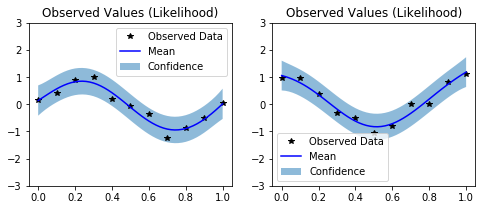

In [6]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]
test_x = Variable(torch.linspace(0, 1, 51))
# Make y index vectors of the same length as test data
y1_inds_test = Variable(torch.zeros(51).long())
y2_inds_test = Variable(torch.ones(51).long())

# Make predictions
observed_pred_y1 = likelihood(model(test_x, y1_inds_test))
observed_pred_y2 = likelihood(model(test_x, y2_inds_test))

# Define plotting function
def ax_plot(ax, train_y, rand_var, title):
    # Get lower and upper confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Predictive mean as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade in confidence 
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot both tasks
ax_plot(y1_ax, train_y1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, observed_pred_y2, 'Observed Values (Likelihood)')